<a href="https://colab.research.google.com/github/Ismail-Armutcu/Algorithms-for-Interactive-Sytems/blob/main/MMI513_PA5_PathFinding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment #5
# Path Finding
## **Fall 2023/24 Semester**

Implement both Dijkstra and $A^*$ algorithms. Using the same input compare their computational efficiencies.

1. Implement both of the algorithms
2. Give both the same problem domains, converted to a graph with appropriate processing
3. Run the algorithms multiple times for randomly selected start-end nodes and log the running time (e.g. 10 time for each randomly selected pair for 10 random selections)
4. Plot the average running time and the dispersion of the running time.
5. Comment on which algorithm works faster and why.

## Preamble

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import math
import scipy.spatial as spat
from shapely import MultiPoint, Polygon, LineString
from shapely.ops import triangulate
import random
import time

# Utility Functions



In [144]:
def plotpoly(poly, flag=True): ## Plots a polynomial
    fig, ax = plt.subplots()
    if flag:
      ax.plot(poly[:, 1], poly[:, 0], 'o-r', linewidth=2)
    else:
      ax.plot(poly[:, 0], poly[:, 1], 'o-r', linewidth=2)
      ax.plot([poly[-1, 0], poly[0, 0]], [poly[-1, 1], poly[0,1]], 'o-r', linewidth=2)
    return ax

# Triangulation is carried out in the convex hull and not within the polygon.
# We will select triangles within the polygon
def triangulate_within(polygon):
    return [triangle for triangle in triangulate(polygon) if triangle.within(polygon)]

def getgraph(points): # We are not doing any type-checking, which is not good!
  polygon = Polygon(points)
  # trig = triangulate(roompoly)
  trig = triangulate_within(polygon)
  vertices = []
  edges = []
  for ply in trig:
    neighs = ply.intersection(trig)
    cp1 = ply.centroid
    vertices.append(cp1)
    ln = len(neighs)
    for ind in range(ln):
      neig = neighs[ind]
      # Two triangles are neighbours only when their intersection is a LineString
      if type(neig) == LineString:
        cp2 = trig[ind].centroid
        edges.append(LineString([cp1, cp2])) # We are adding all edges twice so we will have to eliminate them at the end
  # Eliminate the duplicates now
  edgeiter = edges.copy()
  for edge in edgeiter:
    if len(np.where(edge.equals(edges)==True)[0]) > 1:
      edges.remove(edge)
  return vertices, edges

def convertGraph(vertices,edges): # Converts the vertices and edges returned from getGraph to be suitable for A* and Dijkstra algorithms
  v = []
  for vertice in vertices:
    v.append((round(vertice.x,2), round(vertice.y,2)))
  e = []
  for edge in edges:
    p1x = round(edge.coords[0][0],2)
    p1y = round(edge.coords[0][1],2)
    p2x = round(edge.coords[1][0],2)
    p2y = round(edge.coords[1][1],2)
    e.append(((p1x,p1y),(p2x,p2y)))
  return v, e

def plotgraph(vertices, edges): ## Plots the graph with edge weights in manhattan weight
  x, y = [], []
  for v in vertices:
    x.append(v[0])
    y.append(v[1])

  plt.scatter(np.array(x), np.array(y))
  plt.axis('equal')  # Equal aspect ratio
  for e in edges:
    plt.plot([e[0][0], e[1][0]], [e[0][1], e[1][1]], 'm')
    x = (e[0][0]+e[1][0])/2
    y = (e[0][1]+e[1][1])/2
    plt.text(x,y, f'{round(abs(e[0][0]-e[1][0])+ abs(e[0][1]-e[1][1]),2)}', verticalalignment='bottom', horizontalalignment='right',color='magenta')  # Text annotation
    ## Weight of an edge in manhattan metric


def plotPath(vertices,edges,start,end): ## Plots the calculated path from the start and end vertices
  x, y = [], []
  for v in vertices:
    x.append(v[0])
    y.append(v[1])
    plt.scatter(np.array(x), np.array(y))
    plt.axis('equal')  # Equal aspect ratio
  for e in edges:
    plt.plot([e[0][0], e[1][0]], [e[0][1], e[1][1]], 'k')
    plt.text(s[0], s[1], 'Start', verticalalignment='bottom', horizontalalignment='right', color='blue')
    plt.text(r[0], r[1], 'End', verticalalignment='bottom', horizontalalignment='right', color='blue')
    ## Specify start and end vertices



##Utility Structures and Functions for A-Star and Dijkstra Algorithms

In [145]:
## A matrix class to store the distance between vertices this class implements g(s->r) function in A-Star and distance function in Dijkstra
class weightMatrix:
    def __init__(self,vertices):
      self.vertices = vertices
      self.matrix = []
      for i in range(len(vertices)):
        self.matrix.append([np.inf]*len(vertices))

    def __getitem__(self, index):
        s,v = index
        return self.matrix[self.vertices.index(s)][self.vertices.index(v)]

    def __setitem__(self, index, value):
        s,v = index
        self.matrix[self.vertices.index(s)][self.vertices.index(v)] = value

#Heuristic measure takes the max of the vertical
#and horizontal distance to goal vertex
def h(v,r):
  return max(abs(r[0]-v[0]),abs(r[1]-v[1]))

#Weight of and edge in manhattan metric
def manhattanDistance(v,u):
  return abs(v[0]-u[0])+ abs(v[1]-u[1])

#Return the vertices that can be accessed from the selected vertice, similar to neighbour
def getSuccessors(selectedVertice,edges,vertices):
  successorList = []
  for e in edges:
    if(e[0] == selectedVertice and e[1] in vertices):
      if(not(e[1] in successorList)):
        successorList.append(e[1])
    elif(e[1] == selectedVertice and e[0] in vertices):
      if(not(e[0] in successorList)):
        successorList.append(e[0])
  return successorList

def calculatePathFromMapping(res,s,r): ## Calculate the path from the result of A* or Dijkstra Algorithm
  prev = res[r]
  steps = []
  steps.append(r)
  steps.append(prev)
  while(prev != s):
    prev = res[prev]
    steps.append(prev)

  travelledEdges = []
  for i in range(len(steps)-1):
    travelledEdges.append(((steps[i]),(steps[i+1])))
  return steps,travelledEdges




##$A^{*}$ Algorithm Implementation

In [146]:
def aStar(vertices,edges,s,r):
  g = weightMatrix(vertices) #function g(s->v)
  S = []  #OpenList S
  pi = {} #Mapping pi: V -> V
  for v in vertices:
    pi[v] = None
    g[s,v] = np.inf
  g[s, s] = 0
  S.append(s)
  g[s,r] = h(s,r) ## Precalculate h(s,r)
  selectedVertice = s ##First start with the starting vertice
  while len(S) != 0:
    minWeight = np.inf
    for vPrime in S:  ##Find the vertice that minimizes g[s,vPrime]+ h(vPrime,r)
      if(vPrime != s):
        if((g[s,vPrime]+ h(vPrime,r) )< minWeight ):
          minWeight = g[s,vPrime]+ h(vPrime,r)
          selectedVertice = vPrime

    if(selectedVertice == r and g[selectedVertice,r]< np.inf): ## If the target vertice is reached, terminate
      return pi

    if(selectedVertice in S): ## S <- S \ {v}
       S.pop(S.index(selectedVertice))

    for u in getSuccessors(selectedVertice,edges,vertices): ## For each successor of selectedVertice
      if(pi[u] == None): ## If it is NIL then open u
        if(not (u in S)): ## S <- S U {u}
          S.append(u)
        g[s,u] = g[s,selectedVertice] + manhattanDistance(selectedVertice,u) ## Update the weight
        pi[u] = selectedVertice   ##Update the mapping
        g[u,r] = h(u,r)   ##Precalculate h(u,r)

      elif((u in S) and ((g[s,selectedVertice] + manhattanDistance(selectedVertice,u)) < g[s,u])): ## g(s->v) + weight(v,u) < g(s->u) then open u
        if(not (u in S)): ## S <- S U {u}
          S.append(u)
        g[s,u] = g[s,selectedVertice] + manhattanDistance(selectedVertice,u) ## Update the weight
        pi[u] = selectedVertice ##Update the mapping
        g[u,r] = h(u,r) ##Precalculate h(u,r)

##Testing $A^{*}$ algorithm

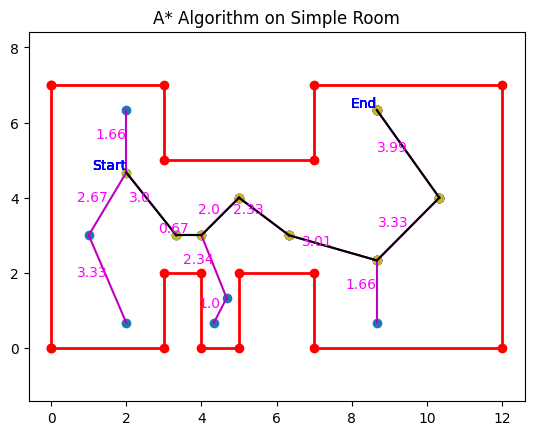

In [159]:
simproom = np.array([[0,0], [3,0], [3,2], [4,2], [4,0], [5,0], [5,2], [7,2], [7,0], [12,0], [12,7], [7,7], [7,5], [3,5], [3, 7], [0,7]])
vertices, edges= getgraph(simproom)
vertices, edges= convertGraph(vertices, edges)


s,r = random.sample(vertices, 2)
res = aStar(vertices,edges,s,r)

steps,travelledEdges = calculatePathFromMapping(res,s,r)


plotpoly(simproom,False)
plotgraph(vertices, edges)
plotPath(steps, travelledEdges,s,r)
plt.title('A* Algorithm on Simple Room')
plt.show()

## Dijkstra's Algorithm Implementation
- Note that the weight of and edge is calculated in manhattan metric

In [148]:
def dijkstra(vertices,edges,s,r):
  dist = weightMatrix(vertices) #function dist[v]
  Q = []  ## Visited vertices
  prev = {} #Mapping previous vertex: V -> V

  for v in vertices: ##Initialize
    dist[s,v] = np.inf ##weights as infinity
    prev[v] = None  ## previous vertice as NIL
    Q.append(v)   ## Fill the list

  dist[s,s] = 0   ## Starting vertice distance is zero
  u = s   ## Current vertice is initially start vertice

  while(len(Q) !=0):  ## While Q is not empty

    minWeight = np.inf
    for vPrime in Q:  ## Find the vertex with min distance
      if(vPrime != s):
        if( dist[s,vPrime]< minWeight ):
          minWeight = dist[s,vPrime]
          u = vPrime

    if(u == r and dist[u,r]< np.inf): ##If the target vertice is reached terminate
      return prev                     ## Because we are interested in the shortest path from start to end

    if(u in Q):   ##Remove u from Q
      Q.pop(Q.index(u))

    for v in getSuccessors(u,edges,Q):    ## For each neighbor v of u still in Q
      alt = dist[s,u] + manhattanDistance(u,v) ## The weight of an edge is calculated as manhattan distance metric

      if alt < dist[s,v] : ## If a shorter path is found, update
        dist[s, v] = alt
        prev[v] = u

  return prev


## Testing Dijkstra's Algorithm

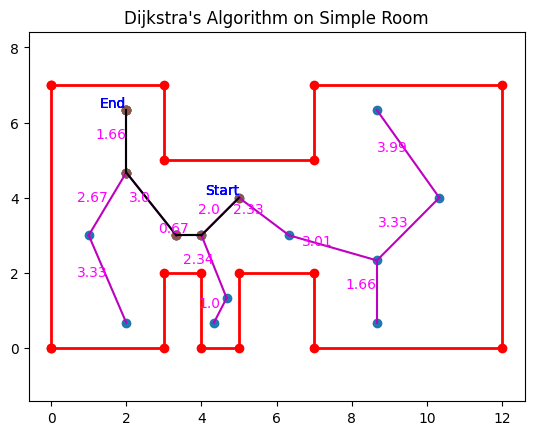

In [160]:
s,r = random.sample(vertices, 2)
res = dijkstra(vertices,edges,s,r)

steps,travelledEdges = calculatePathFromMapping(res,s,r)


plotpoly(simproom,False)
plotgraph(vertices, edges)
plotPath(steps, travelledEdges,s,r)
plt.title('Dijkstra\'s Algorithm on Simple Room')
plt.show()

## A function to create a random convex contour
*Cited from https://stackoverflow.com/questions/50731785/create-random-shape-contour-using-matplotlib
* OriolAbril answer

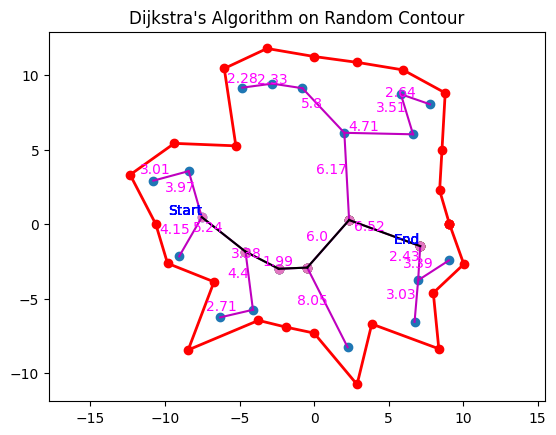

In [150]:
##Cited from https://stackoverflow.com/questions/50731785/create-random-shape-contour-using-matplotlib
## OriolAbril answer
def createRandomContour(n = 8, r = 0.2):
  #n: Number of possibly sharp edges
  #r: magnitude of the perturbation from the unit circle,
  #r: should be between 0 and 1
  N = n*3+1 # number of points in the Path
  # There is the initial point and 3 points per cubic bezier curve. Thus, the curve will only pass though n points, which will be the sharp edges, the other 2 modify the shape of the bezier curve

  angles = np.linspace(0,2*np.pi,N)
  verts = np.stack((np.cos(angles),np.sin(angles))).T*(2*r*np.random.random(N)+1-r)[:,None]
  verts[-1,:] = verts[0,:] # Using this instad of Path.CLOSEPOLY avoids an innecessary straight line

  return verts*10

shape = createRandomContour(8,0.3) ## Create a random contour with 4 * 10 +1 = 41points
plotpoly(shape,False) ## Plot the random shape
vertices, edges= getgraph(shape) ## Triangulate and get a graph representation of the contour
vertices, edges= convertGraph(vertices, edges) ##Convert to domain
plotgraph(vertices, edges)
plt.title('Dijkstra\'s Algorithm on Random Contour')

s,r = random.sample(vertices, 2)
res = dijkstra(vertices,edges,s,r)
steps,travelledEdges = calculatePathFromMapping(res,s,r)
plotPath(steps, travelledEdges,s,r)



#Since both the simple room and random contour graphs have only one path between start and end Lets try a custom graph

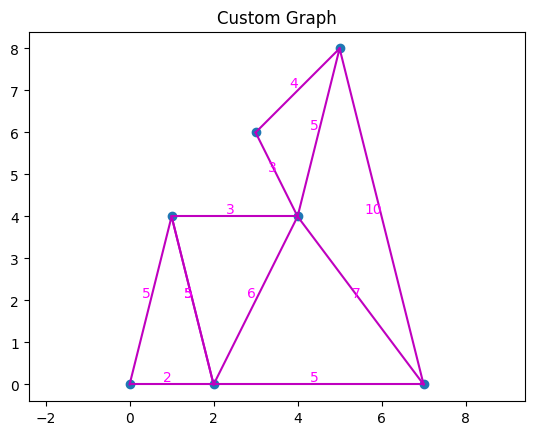

In [161]:
vertices = [(0,0),(2,0),(7,0),(1,4),(4,4),(3,6),(5,8)]
edges = [[ (0,0,) , (2,0)],[(2,0) , (7,0)],[ (0,0) , (1,4)],[ (2,0) , (1,4)],[ (1,4) , (4,4)],[ (1,4) , (2,0)],[ (2,0) , (4,4)],[ (4,4) , (3,6)]
         ,[ (4,4) , (5,8)],[ (4,4) , (7,0)],[ (7,0) , (5,8)],[ (3,6) , (5,8)]]


plotgraph(vertices, edges)
plt.title('Custom Graph')
plt.show()


Testing Dijkstra and $A^{*}$ on Custom Graph

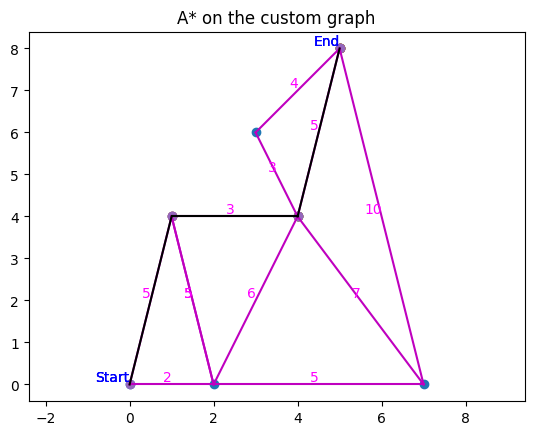

In [163]:
s = (0,0)
r = (5,8)
res = aStar(vertices,edges,s,r)


steps,travelledEdges = calculatePathFromMapping(res,s,r)

plotgraph(vertices, edges)
plotPath(steps,travelledEdges,s,r)
plt.title('A* on the custom graph')
plt.show()



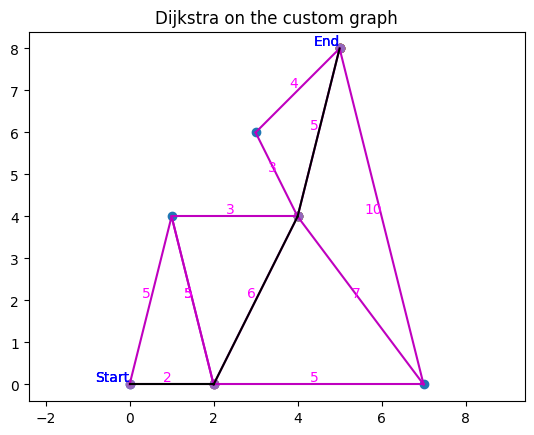

In [164]:
s = (0,0)
r = (5,8)
res = dijkstra(vertices,edges,s,r)

steps,travelledEdges = calculatePathFromMapping(res,s,r)

plotgraph(vertices, edges)
plotPath(steps,travelledEdges,s,r)
plt.title('Dijkstra on the custom graph')
plt.show()

## Runtime Computation
* Log the runtimes 10 times for 10 randomly selected start end pairs

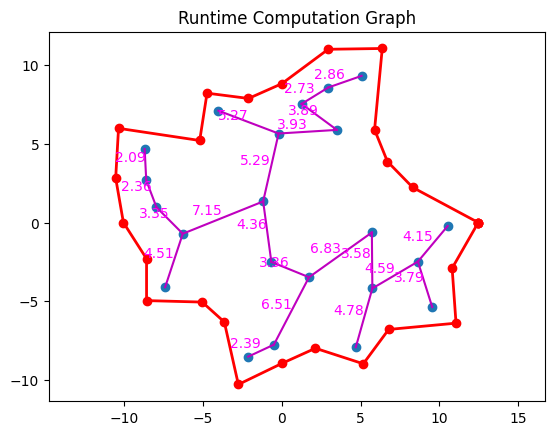

In [165]:
shape = createRandomContour(8,0.3) ## Create a random contour with 4 * 10 +1 = 41points
plotpoly(shape,False) ## Plot the random shape

vertices, edges= getgraph(shape) ## Triangulate and get a graph representation of the contour
vertices, edges= convertGraph(vertices, edges) ##Convert to domain
plotgraph(vertices, edges)
plt.title('Runtime Computation Graph')

totalTimeAStar = []
totalTimeDijkstra = []

for randomSelection in range(10):
  s,r = random.sample(vertices, 2)
  timeAStar = []
  timeDijkstra = []
  for iteratate in range(10):

    startAstar = time.time()
    aStar(vertices,edges,s,r)
    endAstar = time.time()
    timeAStar.append(endAstar-startAstar)

    startDijkstra = time.time()
    dijkstra(vertices,edges,s,r)
    endDijkstra = time.time()
    timeDijkstra.append(endDijkstra-startDijkstra)

  totalTimeAStar.append(timeAStar)
  totalTimeDijkstra.append(timeDijkstra)


##Average Runtimes for $A^{*}$ and Dijkstra

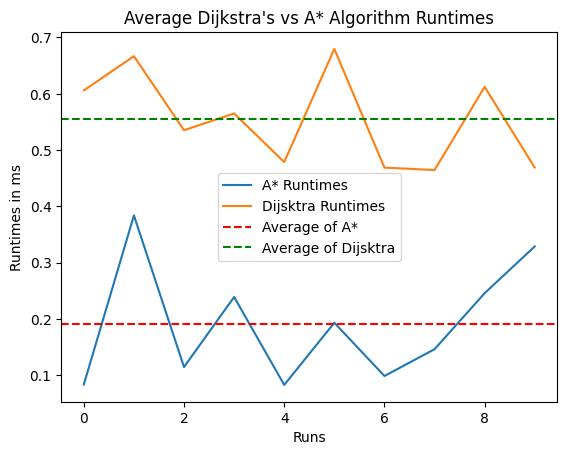

In [166]:
totalAverageAStar = 0
averageAStar = []
for t in totalTimeAStar:
  averageAStar.append((sum(t)/10)*1000)
  totalAverageAStar += sum(t)/10
totalAverageAStar = totalAverageAStar/10

totalAverageDijkstra = 0
averageDijsktra = []
for t in totalTimeDijkstra:
  averageDijsktra.append((sum(t)/10)*1000)
  totalAverageDijkstra += sum(t)/10
totalAverageDijkstra = totalAverageDijkstra/10

plt.plot(averageAStar, label='A* Runtimes')
plt.plot(averageDijsktra, label='Dijsktra Runtimes')

plt.ylabel('Runtimes in ms')
plt.xlabel('Runs')
plt.title('Average Dijkstra\'s vs A* Algorithm Runtimes')

plt.axhline(y=totalAverageAStar*1000, color='r', linestyle='--', label='Average of A*')
plt.axhline(y=totalAverageDijkstra*1000, color='g', linestyle='--', label='Average of Dijsktra')
plt.legend()
plt.show()


##Dispersion of Runtimes for $A^{*}$ and Dijkstra

* Note that the dispersion plot graph is taken from ChatGpt

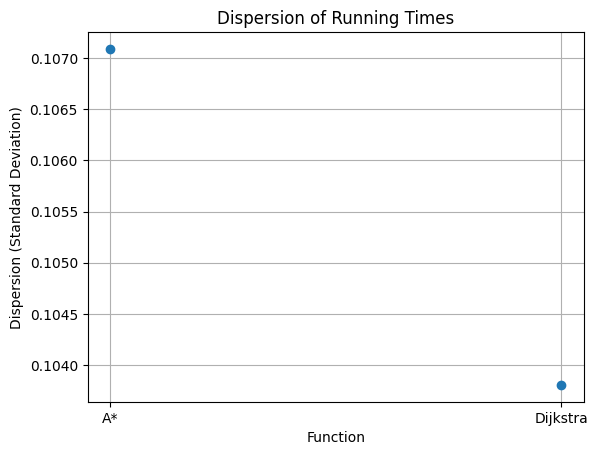

In [167]:
totalAverageAStar = 0
averageAStar = []
for times in totalTimeAStar:
  for t in times:
    averageAStar.append(t*1000)


averageDijsktra = []
for times in totalTimeDijkstra:
  for t in times:
    averageDijsktra.append(t*1000)


aStarDispersion = (sum((x - sum(averageAStar) / len(averageAStar)) ** 2 for x in averageAStar) / len(averageAStar)) ** 0.5
dijkstraDispersion = (sum((x - sum(averageDijsktra) / len(averageDijsktra)) ** 2 for x in averageDijsktra) / len(averageDijsktra)) ** 0.5

# Plotting
plt.errorbar(['A*', 'Dijkstra'], [aStarDispersion, dijkstraDispersion], yerr=[0, 0], fmt='o')

# Add labels and title
plt.xlabel('Function')
plt.ylabel('Dispersion (Standard Deviation)')
plt.title('Dispersion of Running Times')
plt.grid(True)

# Show plot
plt.show()

## Comments:
In our case:
* A* algorithm works faster than the Dijkstra's algorithm
* A* is faster because it uses a heuristic function and makes educated guesses on which vertex to explore. On the other hand, Dijkstra's algorithm explores vertices one by one.